In [1]:
# Full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# 
from lib_modeling import *
from lib_feature_engineering import *

from sklearn.preprocessing import Imputer

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load data

- Load train + tvt = train_filtered for features evaluation
- Load train/test for applying mean encoding

In [4]:
# load train/test data
data_path = "home-credit-default-risk/application_train.csv"
pdf_train = pd.read_csv(data_path)

data_path = "home-credit-default-risk/application_test.csv"
pdf_test = pd.read_csv(data_path)

# filter by tvt code
pdf_tvt_extend = pd.read_pickle("pdf_tvt_extend.pkl", compression="bz2")
pdf_train_filtered = (pdf_tvt_extend.query("tvt_code == 'train'")
                      .merge(pdf_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                      .drop(columns=["tvt_code"]))
pdf_train_filtered.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [5]:
# load previous application
data_path = "home-credit-default-risk/previous_application.csv"
pdf_prev_app = pd.read_csv(data_path)
print(pdf_prev_app.shape)
pdf_prev_app.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# load meta data
meta_path = "../02_pandas/reports/report_previous_application.csv"
pdf_meta = pd.read_csv(meta_path)

# Preprocessing data

## NAME_CONTRACT_TYPE

In [7]:
pdf_prev_app["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                346   
Name: NAME_CONTRACT_TYPE, dtype: int64

In [8]:
# số lượng XNA khá nhỏ, có 346 records. Replace thành Cash loans
pdf_prev_app.loc[pdf_prev_app["NAME_CONTRACT_TYPE"] == "XNA", "NAME_CONTRACT_TYPE"] = "Cash loans"
pdf_prev_app["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         747899
Consumer loans     729151
Revolving loans    193164
Name: NAME_CONTRACT_TYPE, dtype: int64

## AMT_ANNUITY

In [9]:
pdf_prev_app["AMT_ANNUITY"].isna().mean()

0.22286665062081865

In [10]:
pdf_prev_app[pdf_prev_app["AMT_ANNUITY"].isna()]["NAME_CONTRACT_STATUS"].value_counts()

Canceled        305805
Refused         40898 
Unused offer    25524 
Approved        8     
Name: NAME_CONTRACT_STATUS, dtype: int64

In [11]:
# AMT_ANNUITY bị null khi tình trạng của HĐ là hủy. 
# chỉ một số ít AMT_ANNUITY là null nhưng tình trạng của HĐ là approved.
# Fill giá trị này là 0
pdf_prev_app.loc[pdf_prev_app["AMT_ANNUITY"].isna(), "AMT_ANNUITY"] = 0
pdf_prev_app["AMT_ANNUITY"].isna().mean()

0.0

## AMT_DOWN_PAYMENT

KH phải trả số tiền ban đầu là bao nhiêu.

In [12]:
pdf_prev_app["AMT_DOWN_PAYMENT"].isna().mean()

0.536364801157217

In [13]:
# Mặc định KH không trả giá trị ban đầu mà vay toàn bộ. Fill 0 cho các giá trị null này
pdf_prev_app.loc[pdf_prev_app["AMT_DOWN_PAYMENT"].isna(), "AMT_DOWN_PAYMENT"] = 0
pdf_prev_app["AMT_DOWN_PAYMENT"].isna().mean()

0.0

## AMT_GOODS_PRICE

Số tiền của sản phẩm mà khách hàng muốn vay trả góp

In [14]:
pdf_prev_app["AMT_GOODS_PRICE"].isna().mean()

0.23081772754868538

In [15]:
# Có rất nhiều giá trị 0 tại cột AMT_CREDIT khi AMT_GOODS_PRICE là Null
series_check = pdf_prev_app[pdf_prev_app["AMT_GOODS_PRICE"].isna()]["AMT_CREDIT"]
series_check[series_check == 0.0].count() * 1.0 / series_check.shape[0]

0.8664747156401178

In [16]:
# giải ngân là 0, tình trạng của HĐ là approved
pdf_prev_app.loc[series_check[series_check == 0.0]]["NAME_CONTRACT_STATUS"].value_counts()

Approved    334039
Name: NAME_CONTRACT_STATUS, dtype: int64

In [17]:
# giải ngân là 0, mục đích vay là XAP
pdf_prev_app.loc[series_check[series_check == 0.0]]["NAME_CASH_LOAN_PURPOSE"].value_counts()

XAP    334039
Name: NAME_CASH_LOAN_PURPOSE, dtype: int64

In [18]:
# Fill 0 cho các giá trị AMT_GOODS_PRICE là 0
pdf_prev_app.loc[pdf_prev_app["AMT_GOODS_PRICE"].isna(), "AMT_GOODS_PRICE"] = 0
pdf_prev_app["AMT_GOODS_PRICE"].isna().mean()

0.0

## RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED

Lãi suất của khoản vay

In [19]:
pdf_prev_app["RATE_DOWN_PAYMENT"].isna().mean()

0.536364801157217

In [20]:
pdf_prev_app["RATE_INTEREST_PRIMARY"].isna().mean()

0.9964369835242669

In [21]:
pdf_prev_app["RATE_INTEREST_PRIVILEGED"].isna().mean()

0.9964369835242669

In [22]:
# Fill median với giả định ngân hàng đa phần cho vay với tỉ lệ này nên hiếm khi điền thông tin cho trường này
imputer = Imputer(strategy = 'median')
pdf_prev_app['RATE_DOWN_PAYMENT'] = imputer.fit_transform(pdf_prev_app[['RATE_DOWN_PAYMENT']])
pdf_prev_app['RATE_INTEREST_PRIMARY'] = imputer.fit_transform(pdf_prev_app[['RATE_INTEREST_PRIMARY']])
pdf_prev_app['RATE_INTEREST_PRIVILEGED'] = imputer.fit_transform(pdf_prev_app[['RATE_INTEREST_PRIVILEGED']])

## CNT_PAYMENT

Kì hạn của khoản vay

In [23]:
pdf_prev_app["CNT_PAYMENT"].isna().mean()

0.22286365699245725

In [24]:
# Có rất nhiều giá trị 0 tại cột AMT_CREDIT khi CNT_PAYMENT là Null
series_check = pdf_prev_app[pdf_prev_app["CNT_PAYMENT"].isna()]["AMT_CREDIT"]
series_check[series_check == 0.0].count() * 1.0 / series_check.shape[0]

0.9003707385218817

In [25]:
pdf_prev_app.loc[series_check[series_check == 0.0].index]["NAME_CONTRACT_STATUS"].value_counts()

Canceled        305566
Refused         29087 
Unused offer    492   
Name: NAME_CONTRACT_STATUS, dtype: int64

In [26]:
pdf_prev_app.loc[series_check[series_check > 0.0].index]["NAME_CONTRACT_STATUS"].value_counts()

Unused offer    25032
Refused         11810
Canceled        239  
Approved        4    
Name: NAME_CONTRACT_STATUS, dtype: int64

In [27]:
ls_days = [cname for cname in pdf_prev_app.columns if "DAYS" in cname]
ls_days

['DAYS_DECISION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION']

In [28]:
# Những rows có CNT_PAYMENT là null thì các trường DAYS* đều là null. 
# Có thể KH đã trả trước.
pdf_prev_app.loc[series_check.index][ls_days].describe()

,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,372230.0000,0.0,0.0,0.0,0.0,0.0
mean,-316.8921,NaN,NaN,NaN,NaN,NaN
std,325.8686,NaN,NaN,NaN,NaN,NaN
min,-2580.0000,NaN,NaN,NaN,NaN,NaN
25%,-363.0000,NaN,NaN,NaN,NaN,NaN
50%,-250.0000,NaN,NaN,NaN,NaN,NaN
75%,-153.0000,NaN,NaN,NaN,NaN,NaN
max,-2.0000,NaN,NaN,NaN,NaN,NaN


In [29]:
# Fill 0 cho các trường hợp này
pdf_prev_app.loc[pdf_prev_app["CNT_PAYMENT"].isna(), "CNT_PAYMENT"] = 0
pdf_prev_app["CNT_PAYMENT"].isna().mean()

0.0

## DAYS_FIRST_DRAWING: 

Ngày giải ngân đầu tiên

In [30]:

# Đây là trường hợp 
# Đặt các món vay này có PRE_PAID_ALL = 1
# Fill giá trị PRE_PAID_ALL các món trên là 1


In [31]:
pdf_prev_app["DAYS_FIRST_DRAWING"].isna().mean()

0.40298129461254667

In [32]:
# DAYS_FIRST_DRAWING bị null mà vẫn được approved?
# có thể KH trả toàn bộ tiền, thay đổi ý kiến trước khi nhận được tiền vay
pdf_prev_app[pdf_prev_app["DAYS_FIRST_DRAWING"].isna()]["NAME_CONTRACT_STATUS"].value_counts()

Canceled        316319
Refused         290678
Approved        39632 
Unused offer    26436 
Name: NAME_CONTRACT_STATUS, dtype: int64

In [33]:
# tạo feature xác định có phải là prepaid user hay không
pdf_prev_app["PREPAID_USER"] = 0
pdf_prev_app.loc[pdf_prev_app["DAYS_FIRST_DRAWING"].isna(), "PREPAID_USER"] = 1
pdf_prev_app["PREPAID_USER"].value_counts()

0    997149
1    673065
Name: PREPAID_USER, dtype: int64

## Handling DAYS_* == 365243

Các giá trị 365243 thể hiện giá trị vô hạn, tương đương null value. Do đó, fill toàn bộ giá trị này thành null và đánh dấu điểm dị biệt này

In [34]:
def handling_days(pdf_input, cname):
    # Create an anomalous flag column
    pdf_input["{}_ANOM".format(cname)] = pdf_input[cname] == 365243

    # Replace the anomalous values with nan
    pdf_input[cname] = pdf_input[cname].replace({365243: np.nan})

    # Calculate years
    pdf_input["{}_TO_YEARS".format(cname)] = pdf_input[cname] / -365
    pdf_input.drop(columns=[cname], inplace=True)

    return pdf_input


for cname in ls_days:
    print("{}: {}".format(cname, (pdf_prev_app[cname] == 365243).mean()))
    pdf_prev_app = handling_days(pdf_prev_app, cname)

DAYS_DECISION: 0.0
DAYS_FIRST_DRAWING: 0.559475612107
DAYS_FIRST_DUE: 0.0243352049498
DAYS_LAST_DUE_1ST_VERSION: 0.0561987865028
DAYS_LAST_DUE: 0.126463435224
DAYS_TERMINATION: 0.135259912802


## Ordinal encoding

NAME_CASH_LOAN_PURPOSE, NAME_CONTRACT_STATUS, NAME_PAYMENT_TYPE, CODE_REJECT_REASON, NAME_CLIENT_TYPE, NAME_GOODS_CATEGORY, NAME_PORTFOLIO, CHANNEL_TYPE, NAME_SELLER_INDUSTRY, NAME_YIELD_GROUP

In [35]:
def ordinal_encoding(pdf_input, cname):
    # ranking by count frequency
    series_ranking = pdf_prev_app[cname].value_counts()
    
    # generate mapping to ordinal
    cate_map = dict(zip(series_ranking.index, range(series_ranking.shape[0])))
    
    # transform values
    pdf_prev_app["{}_ordinal".format(cname)] = pdf_prev_app[cname].apply(lambda x: cate_map[x])
    pdf_input["{}_ordinal".format(cname)] = pdf_input[cname].apply(lambda x: cate_map[x])
    
    return pdf_input

In [36]:
ls_to_ordinal = [
    "NAME_CASH_LOAN_PURPOSE",
    "NAME_CONTRACT_STATUS",
    "NAME_PAYMENT_TYPE",
    "CODE_REJECT_REASON",
    "NAME_CLIENT_TYPE",
    "NAME_GOODS_CATEGORY",
    "NAME_PORTFOLIO",
    "CHANNEL_TYPE",
    "NAME_SELLER_INDUSTRY",
    "NAME_YIELD_GROUP"    
]
for cname in ls_to_ordinal:
    print("Encoding {}...".format(cname))
    pdf_prev_app = ordinal_encoding(pdf_prev_app, cname)
    
# drop columns
pdf_prev_app.drop(columns=ls_to_ordinal, inplace=True)

Encoding NAME_CASH_LOAN_PURPOSE...
Encoding NAME_CONTRACT_STATUS...
Encoding NAME_PAYMENT_TYPE...
Encoding CODE_REJECT_REASON...
Encoding NAME_CLIENT_TYPE...
Encoding NAME_GOODS_CATEGORY...
Encoding NAME_PORTFOLIO...
Encoding CHANNEL_TYPE...
Encoding NAME_SELLER_INDUSTRY...
Encoding NAME_YIELD_GROUP...


## NAME_TYPE_SUITE

Ai đi cùng KH tới vay

In [37]:
pdf_prev_app["NAME_TYPE_SUITE"].isna().mean()

0.4911975351661524

In [38]:
# Fill na là Unaccompanied
pdf_prev_app.loc[pdf_prev_app["NAME_TYPE_SUITE"].isna(), "NAME_TYPE_SUITE"] = "Unaccompanied"
pdf_prev_app["NAME_TYPE_SUITE"].isna().mean()

0.0

# Categorical features

In [39]:
# get list categorical attributes
# ls_cate = pdf_meta.query("sub_type == 'object'")["name"].tolist()
series_type = pdf_prev_app.dtypes
ls_cate = series_type[series_type == "object"].index.tolist()
ls_cate

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_TYPE_SUITE',
 'NAME_PRODUCT_TYPE',
 'PRODUCT_COMBINATION']

In [40]:
# construct categorical mapping
dict_onehot = {}
for cate in ls_cate:
    ls_val = pdf_prev_app[cate].value_counts().index.tolist()
    dict_onehot[cate] = ls_val


### one hot

In [41]:
%%time
pdf_onehot = gen_one_hot_feat(pdf_prev_app, dict_onehot, main_key="SK_ID_CURR")
print(pdf_onehot.shape)

(1670214, 40)
CPU times: user 1min 19s, sys: 2.64 s, total: 1min 21s
Wall time: 28.9 s


In [42]:
%%time
pdf_agg01 = agg_common_data(pdf_onehot, ["max", "sum", "mean"], main_key="SK_ID_CURR")
eval_agg01 = feature_evaluate(pdf_train_filtered, pdf_agg01)
display(eval_agg01)

{'FLAG_LAST_APPL_PER_CONTRACT_N': ['max', 'sum', 'mean'],
 'FLAG_LAST_APPL_PER_CONTRACT_Y': ['max', 'sum', 'mean'],
 'NAME_CONTRACT_TYPE_Cash_loans': ['max', 'sum', 'mean'],
 'NAME_CONTRACT_TYPE_Consumer_loans': ['max', 'sum', 'mean'],
 'NAME_CONTRACT_TYPE_Revolving_loans': ['max', 'sum', 'mean'],
 'NAME_PRODUCT_TYPE_XNA': ['max', 'sum', 'mean'],
 'NAME_PRODUCT_TYPE_walk_in': ['max', 'sum', 'mean'],
 'NAME_PRODUCT_TYPE_x_sell': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Children': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Family': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Group_of_people': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Other_A': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Other_B': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Spouse,_partner': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Unaccompanied': ['max', 'sum', 'mean'],
 'PRODUCT_COMBINATION_Card_Street': ['max', 'sum', 'mean'],
 'PRODUCT_COMBINATION_Card_X_Sell': ['max', 'sum', 'mean'],
 'PRODUCT_COMBINATION_Cash': ['max', '

After agg: (338857, 117)


,name,auc,corr,coverage
58,NAME_PRODUCT_TYPE_walk_in_sum,0.5502,0.0642,1.0
59,NAME_PRODUCT_TYPE_walk_in_mean,0.5499,0.0588,1.0
57,NAME_PRODUCT_TYPE_walk_in_max,0.5468,0.0595,1.0
115,NAME_CONTRACT_TYPE_Revolving_loans_sum,0.5378,0.0471,1.0
116,NAME_CONTRACT_TYPE_Revolving_loans_mean,0.5358,0.0394,1.0
100,PRODUCT_COMBINATION_Card_Street_sum,0.5343,0.0501,1.0
101,PRODUCT_COMBINATION_Card_Street_mean,0.5333,0.0416,1.0
98,NAME_CONTRACT_TYPE_Consumer_loans_mean,0.5328,-0.0319,1.0
114,NAME_CONTRACT_TYPE_Revolving_loans_max,0.5327,0.0375,1.0
99,PRODUCT_COMBINATION_Card_Street_max,0.5317,0.0417,1.0


CPU times: user 54.8 s, sys: 1.93 s, total: 56.7 s
Wall time: 14.5 s


In [43]:
eval_agg01.query("auc <= 0.501").shape

(12, 4)

In [44]:
sel_feat = eval_agg01.query("auc > 0.501")["name"].tolist()
pdf_agg01 = pdf_agg01[sel_feat]
print(pdf_agg01.shape)

(338857, 105)


# Numerical features

In [45]:
# get list numerical attributes
# ls_num = pdf_meta.query("sub_type == 'int64'")["name"].tolist()
series_type = pdf_prev_app.dtypes
ls_num = series_type[series_type == "int64"].index.tolist()
ls_num = [col for col in ls_num if col not in ["SK_ID_PREV", "SK_ID_CURR"]]
ls_num

['HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'SELLERPLACE_AREA',
 'PREPAID_USER',
 'NAME_CASH_LOAN_PURPOSE_ordinal',
 'NAME_CONTRACT_STATUS_ordinal',
 'NAME_PAYMENT_TYPE_ordinal',
 'CODE_REJECT_REASON_ordinal',
 'NAME_CLIENT_TYPE_ordinal',
 'NAME_GOODS_CATEGORY_ordinal',
 'NAME_PORTFOLIO_ordinal',
 'CHANNEL_TYPE_ordinal',
 'NAME_SELLER_INDUSTRY_ordinal',
 'NAME_YIELD_GROUP_ordinal']

In [46]:
pdf_num = pdf_prev_app[["SK_ID_PREV", "SK_ID_CURR"] + ls_num].copy()
pdf_num.head()

,SK_ID_PREV,SK_ID_CURR,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,SELLERPLACE_AREA,PREPAID_USER,NAME_CASH_LOAN_PURPOSE_ordinal,NAME_CONTRACT_STATUS_ordinal,NAME_PAYMENT_TYPE_ordinal,CODE_REJECT_REASON_ordinal,NAME_CLIENT_TYPE_ordinal,NAME_GOODS_CATEGORY_ordinal,NAME_PORTFOLIO_ordinal,CHANNEL_TYPE_ordinal,NAME_SELLER_INDUSTRY_ordinal,NAME_YIELD_GROUP_ordinal
0,2030495,271877,15,1,35,0,0,0,0,0,0,1,0,1,2,1
1,2802425,108129,11,1,-1,0,1,0,1,0,0,0,1,4,0,4
2,2523466,122040,11,1,-1,0,1,0,0,0,0,0,1,0,0,2
3,2819243,176158,7,1,-1,0,1,0,0,0,0,0,1,0,0,1
4,1784265,202054,9,1,-1,1,2,2,0,1,0,0,1,0,0,2


In [47]:
%%time
pdf_agg02 = agg_common_data(pdf_num[["SK_ID_CURR"] + ls_num], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")
eval_agg02 = feature_evaluate(pdf_train_filtered, pdf_agg02)
display(eval_agg02)

{'CHANNEL_TYPE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'CODE_REJECT_REASON_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'HOUR_APPR_PROCESS_START': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_CASH_LOAN_PURPOSE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_CLIENT_TYPE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_CONTRACT_STATUS_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_GOODS_CATEGORY_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_PAYMENT_TYPE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_PORTFOLIO_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_SELLER_INDUSTRY_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_YIELD_GROUP_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NFLAG_LAST_APPL_IN_DAY': ['max', 'min', 'sum', 'mean', 'std'],
 'PREPAID_USER': ['max', 'min', 'sum', 'mean', 'std'],
 'SELLERPLACE_AREA': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (338857, 70)


,name,auc,corr,coverage
19,NAME_CONTRACT_STATUS_ordinal_std,0.5657,5.8804e-02,0.8192
59,CODE_REJECT_REASON_ordinal_std,0.5655,5.8077e-02,0.8192
18,NAME_CONTRACT_STATUS_ordinal_mean,0.5623,7.0461e-02,1.0000
3,PREPAID_USER_mean,0.5574,6.0266e-02,1.0000
58,CODE_REJECT_REASON_ordinal_mean,0.5561,6.0062e-02,1.0000
57,CODE_REJECT_REASON_ordinal_sum,0.5548,6.0961e-02,1.0000
68,NAME_YIELD_GROUP_ordinal_mean,0.5519,-4.8816e-02,1.0000
17,NAME_CONTRACT_STATUS_ordinal_sum,0.5516,5.7904e-02,1.0000
55,CODE_REJECT_REASON_ordinal_max,0.5507,4.9633e-02,1.0000
13,NAME_GOODS_CATEGORY_ordinal_mean,0.5494,-3.6786e-02,1.0000


CPU times: user 27.3 s, sys: 1.13 s, total: 28.5 s
Wall time: 8.55 s


In [48]:
eval_agg02.query("auc <= 0.501").shape

(6, 4)

In [49]:
sel_feat = eval_agg02.query("auc > 0.501")["name"].tolist()
pdf_agg02 = pdf_agg02[sel_feat]
print(pdf_agg02.shape)

(338857, 64)


# Continuous features

In [50]:
# get list continuous attributes
# ls_con = pdf_meta.query("sub_type == 'float64'")["name"].tolist()
series_type = pdf_prev_app.dtypes
ls_con = series_type[series_type == "float64"].index.tolist()
ls_con

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'CNT_PAYMENT',
 'NFLAG_INSURED_ON_APPROVAL',
 'DAYS_DECISION_TO_YEARS',
 'DAYS_FIRST_DRAWING_TO_YEARS',
 'DAYS_FIRST_DUE_TO_YEARS',
 'DAYS_LAST_DUE_1ST_VERSION_TO_YEARS',
 'DAYS_LAST_DUE_TO_YEARS',
 'DAYS_TERMINATION_TO_YEARS']

In [51]:
pdf_con = pdf_prev_app[["SK_ID_PREV", "SK_ID_CURR"] + ls_con].copy()
pdf_con.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,CNT_PAYMENT,NFLAG_INSURED_ON_APPROVAL,DAYS_DECISION_TO_YEARS,DAYS_FIRST_DRAWING_TO_YEARS,DAYS_FIRST_DUE_TO_YEARS,DAYS_LAST_DUE_1ST_VERSION_TO_YEARS,DAYS_LAST_DUE_TO_YEARS,DAYS_TERMINATION_TO_YEARS
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,0.0000,0.1828,0.8673,12.0,0.0,0.2000,NaN,0.1151,-0.8219,0.1151,0.1014
1,2802425,108129,25188.615,607500.0,679671.0,0.0,607500.0,0.0516,0.1891,0.8351,36.0,1.0,0.4493,NaN,0.3671,-2.5096,NaN,NaN
2,2523466,122040,15060.735,112500.0,136444.5,0.0,112500.0,0.0516,0.1891,0.8351,12.0,1.0,0.8247,NaN,0.7425,-0.1616,NaN,NaN
3,2819243,176158,47041.335,450000.0,470790.0,0.0,450000.0,0.0516,0.1891,0.8351,12.0,1.0,1.4027,NaN,1.3205,0.4164,0.4986,0.4849
4,1784265,202054,31924.395,337500.0,404055.0,0.0,337500.0,0.0516,0.1891,0.8351,24.0,NaN,2.1397,NaN,NaN,NaN,NaN,NaN


In [52]:
%%time
pdf_agg03 = agg_common_data(pdf_con[["SK_ID_CURR"] + ls_con], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")
eval_agg03 = feature_evaluate(pdf_train_filtered, pdf_agg03)
display(eval_agg03)

{'AMT_ANNUITY': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_APPLICATION': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_CREDIT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_DOWN_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_GOODS_PRICE': ['max', 'min', 'sum', 'mean', 'std'],
 'CNT_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_DECISION_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_FIRST_DRAWING_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_FIRST_DUE_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_LAST_DUE_1ST_VERSION_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_LAST_DUE_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_TERMINATION_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'NFLAG_INSURED_ON_APPROVAL': ['max', 'min', 'sum', 'mean', 'std'],
 'RATE_DOWN_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'RATE_INTEREST_PRIMARY': ['max', 'min', 'sum', 'mean', 'std'],
 'RATE_INTEREST_PRIVILEGED': ['max', 'min', 'sum', 'mean', 's

After agg: (338857, 80)


,name,auc,corr,coverage
64,DAYS_FIRST_DRAWING_TO_YEARS_std,0.6163,-0.0945,0.0005
63,DAYS_FIRST_DRAWING_TO_YEARS_mean,0.5944,-0.0963,0.1830
60,DAYS_FIRST_DRAWING_TO_YEARS_max,0.5943,-0.0961,0.1830
61,DAYS_FIRST_DRAWING_TO_YEARS_min,0.5942,-0.0962,0.1830
44,DAYS_DECISION_TO_YEARS_std,0.5675,-0.0605,0.8192
57,DAYS_LAST_DUE_1ST_VERSION_TO_YEARS_sum,0.5635,-0.0516,1.0000
4,AMT_DOWN_PAYMENT_std,0.5608,-0.0245,0.8192
19,DAYS_FIRST_DUE_TO_YEARS_std,0.5589,-0.0497,0.7013
43,DAYS_DECISION_TO_YEARS_mean,0.5582,-0.0472,1.0000
15,DAYS_FIRST_DUE_TO_YEARS_max,0.5576,-0.0546,0.9937


CPU times: user 33.3 s, sys: 1.39 s, total: 34.7 s
Wall time: 10.7 s


In [53]:
eval_agg03.query("auc <= 0.501").shape

(6, 4)

In [54]:
sel_feat = eval_agg03.query("auc > 0.501")["name"].tolist()
pdf_agg03 = pdf_agg03[sel_feat]
print(pdf_agg03.shape)

(338857, 74)


,SK_ID_PREV
count,338857.0000
mean,4.9290
std,4.2207
min,1.0000
25%,2.0000
50%,4.0000
75%,7.0000
max,77.0000


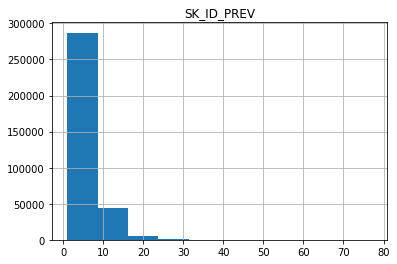

In [55]:
# Có nhiều KH có 1-nhiều khoản vay trước đó
pdf_agg04 = pdf_prev_app.groupby("SK_ID_CURR").agg({"SK_ID_PREV": "count"})
display(pdf_agg04.describe())
pdf_agg04.hist()
plt.show()

# Save features

In [56]:
pdf_feat = pdf_agg01.join(pdf_agg02).join(pdf_agg03).join(pdf_agg04)
print(pdf_feat.shape)

(338857, 244)


In [57]:
%%time
fname = "prev_app"
fname = os.path.join("features", "{}.pkl.bz2".format(fname))
pdf_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")

Store features completed!
CPU times: user 34.3 s, sys: 749 ms, total: 35 s
Wall time: 34.4 s
